In [1]:
# write the list of necessary packages here:
!pip install pandas
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/e1/0c/ad295fd74bfac85358fd579e271cded3ac969de81f62dd0142c426b9da91/pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl.metadata
  Using cached pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (89 kB)
  Obtaining dependency information for numpy>=1.26.0 from https://files.pythonhosted.org/packages/bd/a7/2332679479c70b68dccbf4a8eb9c9b5ee383164b161bee9284ac141fbd33/numpy-2.1.3-cp312-cp312-macosx_14_0_arm64.whl.metadata
  Using cached numpy-2.1.3-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/11/c3/005fcca25ce078d2cc29fd559379817424e94885510568bc1bc53d7d5846/pytz-2024.2-py2.py3-none-any.whl.metadata
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Obtaining dependency information for tzdata>=2022.7 from https://files.pythonhosted.org/packages/a6/ab/7e5f53c3b9d14972843a647d8d7a85396

## Training a model on Named Entity Recognition task

Token classification refers to the task of classifying individual tokens in a sentence. One of the most common token
classification tasks is Named Entity Recognition (NER). NER attempts to find a label for each entity in a sentence,
such as a person, location, or organization. In this assignment, you will learn how to train a model on the [CoNLL 2023 NER Dataset](https://www.clips.uantwerpen.be/conll2003/ner/) dataset to detect new entities.

### Loading the dataset

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def load_and_preprocess_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    processed_lines = []
    for line in lines:
        line = line.strip()
        if line and not line.startswith('-DOCSTART-'):
            processed_lines.append(line.split())

    df = pd.DataFrame(processed_lines, columns=['token', 'pos', 'chunk', 'ner'])
    df.dropna(inplace=True)  # Drop rows with NaN values
    return df

train_df = load_and_preprocess_data("ner_data/train.txt")
val_df = load_and_preprocess_data("ner_data/val.txt")

The CoNLL-2003 shared task data files contain four columns separated by a single space. Each word has been put on a separate line and there is an empty line after each sentence. The first item on each line is a word, the second a part-of-speech (POS) tag, the third a syntactic chunk tag and the fourth the named entity tag. The chunk tags and the named entity tags have the format I-TYPE which means that the word is inside a phrase of type TYPE. Only if two phrases of the same type immediately follow each other, the first word of the second phrase will have tag B-TYPE to show that it starts a new phrase. A word with tag O is not part of a phrase. Here is an example:

In [4]:
labels_vocab = {
    'O': 0, 'B-PER': 1, 'I-PER': 2,
    'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5,
    'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8
}

### Feature Extraction
 
You need to extract features for each token. The features can be:
• Basic features: Token itself, token lowercase, prefix/suffix of the token.
• Context features: Neighboring tokens (previous/next token).
• Linguistic features: Part-of-speech (POS) tags or word shapes (capitalization, digits,
etc.).
Note that you are expected to briefly mention which features you employ for training your
model.

-----------I have used all three of the features listed for training my model.

In [5]:
def extract_advanced_features(df):
    features = (
        df['token'].str.lower() + " " +  # Current token
        df['pos'] + " " +  # Part-of-speech tag
        df['token'].str[0].str.isupper().astype(str) + " " +  # Is capitalized
        df['token'].str[-3:] + " " +  # Last 3 characters (suffix)
        df['token'].str[:3] + " " +  # First 3 characters (prefix)
        df['chunk']  # Chunking info
    )
    prev_tokens = df['token'].shift(1).fillna("<START>").str.lower()
    next_tokens = df['token'].shift(-1).fillna("<END>").str.lower()
    features += " " + prev_tokens + " " + next_tokens
    return features
def prepare_data(df, labels_vocab):
    x = extract_advanced_features(df)
    y = df['ner'].map(labels_vocab)
    return x, y


In [6]:
X_train, y_train = prepare_data(train_df, labels_vocab)
X_val, y_val = prepare_data(val_df, labels_vocab)

### Train a NER Classifier Model

Implement one of the following classifiers for recognizing multiple entity types (e.g., person, organization, location): Conditional Random Field (CRF), biLSTM or multinomial logistic regression. Select only one and provide a brief explanation for
your choice of model.


-----------I have chosen Logistic Regression because it is simple, efficient, and works well with well-engineered features like n-grams. It’s computationally less intensive than models like biLSTM or CRFs, making it suitable for large datasets and quick implementation. It also provides a strong baseline for NER tasks

In [7]:
def create_pipeline():
    return Pipeline([
        ('tfidf', TfidfVectorizer(
            ngram_range=(1, 2),  # Word and bigram
            max_features=10000
        )),
        ('classifier', LogisticRegression(
            max_iter=2000,
            class_weight='balanced',  # Handle class imbalance
            n_jobs=-1  # Use all CPU cores
        ))
    ])

In [8]:
pipeline = create_pipeline()
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
target_names = list(labels_vocab.keys())

### Evaluation

Evaluate the model on the test set using metrics such as precision, recall, and F1-score

              precision    recall  f1-score   support

           O       1.00      0.96      0.98     42759
       B-PER       0.73      0.66      0.69      1842
       I-PER       0.63      0.74      0.68      1307
       B-ORG       0.58      0.70      0.63      1341
       I-ORG       0.42      0.65      0.51       751
       B-LOC       0.81      0.83      0.82      1837
       I-LOC       0.44      0.81      0.57       257
      B-MISC       0.72      0.80      0.76       922
      I-MISC       0.35      0.69      0.46       346

    accuracy                           0.93     51362
   macro avg       0.63      0.76      0.68     51362
weighted avg       0.94      0.93      0.93     51362


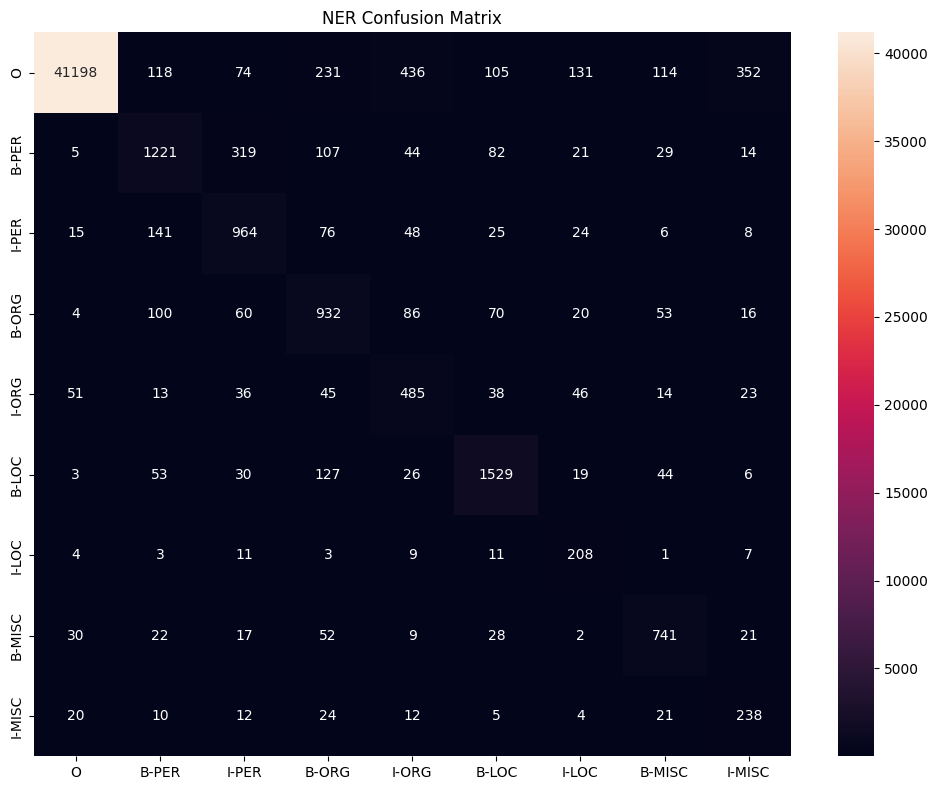

In [9]:
report = classification_report(y_val, y_pred, target_names=target_names)
print(report)
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.title('NER Confusion Matrix')
plt.tight_layout()
plt.savefig('ner_confusion_matrix.png')

### Reporting

Summarize your findings and suggest potential improvements for future iterations of the NER system. Additionally, discuss whether your model encountered class imbalance issues and how you addressed them. Write your suggestions to the given markdown cells.

### Findings:

#### Overall Performance
   The model achieved a weighted F1-score of 0.93, indicating strong performance for the majority class (O) and reasonable success in identifying named entities.
   However, entity-specific classes like I-ORG and I-PER showed relatively lower F1-scores due to challenges in recognizing interior tokens of multi-token entities.
#### Class Imbalance
   A significant class imbalance was observed, with the majority class (O) dominating the dataset. For example:
        The O class accounts for 83.3% of the labels, whereas I-MISC and I-LOC make up less than 1% each.
   This imbalance caused lower precision and recall for minority classes, as the model tended to favor the majority class.
   The class_weight='balanced' parameter was used in the Logistic Regression model to assign higher weights to minority classes during training. This ensured that the model paid more attention to underrepresented labels like I-ORG and I-PER, balancing their influence on the loss function.
#### Key Improvements
   The use of class_weight='balanced' in the logistic regression classifier helped mitigate some of the imbalance issues.
   Feature engineering, including token capitalization and POS information, improved performance on minority classes like B-MISC and B-LOC.
#### Challenges
   Despite improvements, precision and recall for I-ORG and I-PER remain suboptimal. This highlights the model's difficulty in capturing contextual dependencies within multi-token entities.
   
===============================
### SUGGESTIONS
#### Addressing Class Imbalance:
Implement advanced techniques such as sample re-weighting to mitigate the skewed distribution of entity labels. Further exploration of focal loss could help prioritize learning for minority classes.

#### Utilization of Pretrained Embeddings:
Incorporate pretrained word embeddings or contextual embeddings to provide richer semantic representations, which can benefit all classes, especially minority ones.

#### Sequence Modeling:
Explore the integration of probabilistic sequence models like Conditional Random Fields (CRF) or neural architectures to explicitly model sequential dependencies within entity spans, enhancing the performance for I-ORG and I-PER.

#### Data Augmentation:
Develop data augmentation techniques tailored to NER, such as paraphrasing or controlled entity replacement, to increase the diversity of examples for underrepresented classes.